In [203]:
import numpy as np
from scipy.linalg import norm, eigh
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigs as speigs
from scipy.sparse.linalg import norm as spnorm
import matplotlib.pyplot as plt
import cmath

Function to generate five-point stencil to discretize Laplacian

In [323]:
def fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False):
    """
    Creates a five-point stencil finite difference matrix M to approximate the Laplacian operator in eigenvalue problem.
    Excludes the boundary points as they are stationary.

    Args:
        nx (int): Number of grid points in the x direction.
        ny (int): Number of grid points in the y direction.

    Returns:
        np.ndarray: The five-point stencil finite difference matrix M for the inner points.
    """
    dx, dy = Lx / (nx - 1), Ly / (ny - 1)
    N = (nx - 2) * (ny - 2)  # Adjust the size of the matrix to exclude the boundary points
    if sparse:
        M = lil_matrix((N, N))
    else:
        M = np.zeros((N, N))

    for i in range(1, nx - 1):  # Start from 1 and end at nx - 2 to exclude the boundary points
        for j in range(1, ny - 1):  # Start from 1 and end at ny - 2 to exclude the boundary points
            index = (i - 1) * (ny - 2) + (j - 1)  # Adjust the index to account for the excluded boundary points

            # Fill the diagonal elements
            M[index, index] = -2 / dx**2 - 2 / dy**2

            # Fill the left and right neighbor elements
            if i > 1:  # Exclude the left boundary points
                M[index, index - (ny - 2)] = 1 / dx**2
            if i < nx - 2:  # Exclude the right boundary points
                M[index, index + (ny - 2)] = 1 / dx**2

            # Fill the top and bottom neighbor elements
            if j > 1:  # Exclude the top boundary points
                M[index, index - 1] = 1 / dy**2
            if j < ny - 2:  # Exclude the bottom boundary points
                M[index, index + 1] = 1 / dy**2

    if sparse:
        return M.tocsr()
    else:
        return M
    
def size_in_bytes(M):
    """
    Returns the size of the matrix M in bytes.
    """
    if isinstance(M, np.ndarray):
        return M.nbytes
    elif hasattr(M, 'data'):
        return M.data.nbytes + M.indptr.nbytes + M.indices.nbytes
    else:
        raise NotImplementedError("Unknown matrix type")

def add_boundary_to_laplacian(M):
    """
    Adds the edges back to the finite difference matrix M.
    """
    Nx, Ny = M.shape
    if isinstance(M, np.ndarray):
        M_full = np.zeros((Nx + 2, Ny + 2))
        M_full[1:-1, 1:-1] = M
        return M_full
    elif hasattr(M, 'data'):
        M_full = lil_matrix((Nx + 2, Ny + 2))
        M_full[1:-1, 1:-1] = M.todense()
        return M_full.tocsr()
    else:
        raise NotImplementedError("Unknown matrix type")
    
def add_boundary_to_eigvec(eigvec, nx, ny):
    """
    Adds the edges back to the eigenvector eigvec.
    """
    Nx, Ny = nx + 2, ny + 2
    eigvec_full = np.zeros((Nx, Ny))
    eigvec_full[1:-1, 1:-1] = eigvec.reshape(nx, ny)
    return eigvec_full

def solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=False):
    """
    Solves the eigenvalue problem for the finite difference matrix M.
    """
    nx, ny = Nx-2, Ny-2
    N = nx * ny
    dx, dy = Lx / (nx - 1), Ly / (ny - 1)

    M = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=sparse)
    if sparse:
        print('Warning: Sparse matrix is untested.')
        eigvals, eigvecs = speigs(M, k=N, which='SM')
    else:
        eigvals, eigvecs = eigh(M)

    # Sort the eigenvalues and eigenvectors
    if sort_order == 'ascending':
        sort_indices = np.argsort(eigvals)
    elif sort_order == 'descending':
        sort_indices = np.argsort(-eigvals)
    else:
        raise ValueError("sort_order must be 'ascending' or 'descending'")
    eigvals = eigvals[sort_indices]
    eigvecs = eigvecs[:, sort_indices]
    eigfreqs = np.sqrt(-eigvals)
    
    return M, eigvals, eigvecs, eigfreqs

def vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first'):
    plx, ply = plot_shape
    nx, ny = Nx-2, Ny-2
    fig, axs = plt.subplots(plx, ply, figsize=(10, 5), layout='tight')
    fig.suptitle(f'Eigenvectors for an object of size $L_x={Lx}, L_y={Ly}$')
    images = []
    for i, ax in enumerate(axs.flatten()):
        if select == 'first':
            eigvec, eigval, eigfreq = eigvecs[:, i], eigvals[i], eigfreqs[i]
        elif select == 'last':
            eigval, eigvec, eigfreq = eigvals[-(i+1)], eigvecs[:, -(i+1)], eigfreqs[-(i+1)]
        else:
            raise ValueError("select must be 'first' or 'last'")
        eigvec = add_boundary_to_eigvec(eigvec, nx, ny).reshape(Ny, Nx)
        im = ax.imshow(eigvec, origin='lower')
        images.append(im)
        ax.set_title(f'$K={eigval:.2f}$, $f={eigfreq:.2f}$')
        ax.axis('off')

    # Create a single colorbar for all subplots
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.05])
    fig.colorbar(images[0], cax=cbar_ax, orientation='horizontal')

    return fig

Comparison of memory requirements and matrix types

In [319]:
nx, ny = 4, 4
Lx, Ly = 1, 1

M_inner = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False)
print(M_inner)
M_inner = add_boundary_to_laplacian(M_inner)
print(f'Size in memory (dense): {size_in_bytes(M_inner)} bytes')
# print(M_inner)

Ms_inner = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=True)
print(Ms_inner)
Ms_inner = add_boundary_to_laplacian(Ms_inner)
print(f'Size in memory (sparse): {size_in_bytes(Ms_inner)} bytes')

[[-36.   9.   9.   0.]
 [  9. -36.   0.   9.]
 [  9.   0. -36.   9.]
 [  0.   9.   9. -36.]]
Size in memory (dense): 288 bytes
  (0, 0)	-36.0
  (0, 1)	9.0
  (0, 2)	9.0
  (1, 0)	9.0
  (1, 1)	-36.0
  (1, 3)	9.0
  (2, 0)	9.0
  (2, 2)	-36.0
  (2, 3)	9.0
  (3, 1)	9.0
  (3, 2)	9.0
  (3, 3)	-36.0
Size in memory (sparse): 172 bytes


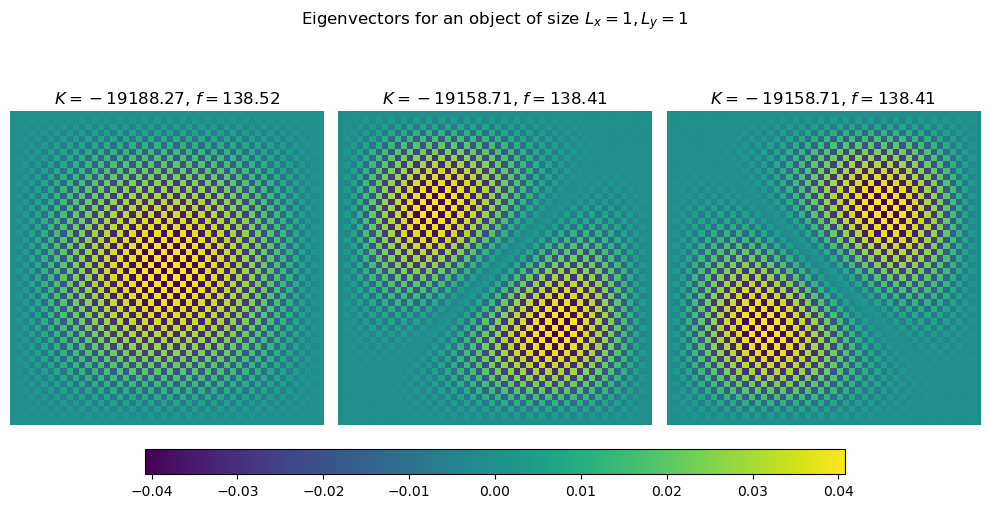

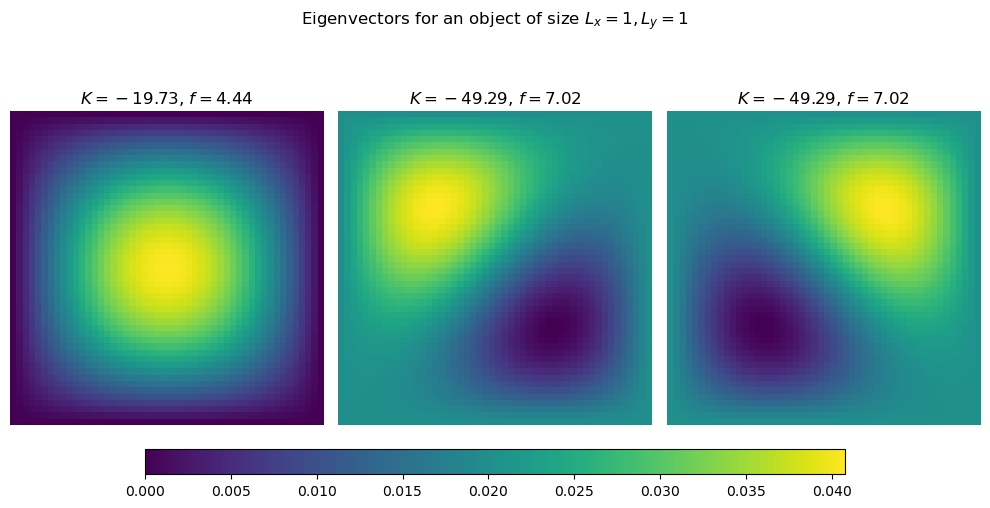

In [324]:
Nx, Ny = 50, 50
nx, ny = Nx-2, Ny-2
Lx, Ly = 1, 1

M, eigvals, eigvecs, eigfreqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=False)

# Lowest eigenvalue eigenvectors 
fig = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first')
fig2 = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='last')